In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision import datasets, transforms , models
from torchvision.models import resnet50, ResNet50_Weights

from torch import nn
import torch.optim as optim

import pandas as pd
import warnings

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


In [3]:
class BoatImages(Dataset):
    def __init__(self, _label_type = "Hull Type" , root = './', train=True):
        self.img_height  = 256  
        self.img_width   = self.img_height
        self.img_height_crop = 256  
        self.img_width_crop  = self.img_height_crop
        self.tabular_data = pd.read_csv("boat_data_cleaned.csv")
        # self.name_from_path = re.compile(r'\./data/\w*\\(.+?)\\')
        self.name_from_path = re.compile(r'\./data/[^/]+/(.+?)/')

        self.train = train
        self.label_type = _label_type
        self.labels , self.categories = pd.factorize(self.tabular_data[self.label_type])

        if self.train:
            self.data_folder = os.path.join(root, 'data/train') # FIXME make a better train test split
        else:
            self.data_folder = os.path.join(root, 'data/test')

        self.dataset_train = datasets.ImageFolder(self.data_folder)

    # a getter function
    @property
    def label_type(self):
        return self._label_type
        
    # a setter function
    @label_type.setter
    def label_type(self, l):
        try:
            self.labels , self.categories = pd.factorize(self.tabular_data[l])
            self._label_type = l
        except:
            self._label_type = "Hull Type"
            self.labels , self.categories = pd.factorize(self.tabular_data[self._label_type])
            warnings.warn("Invalid label_type! Setting label_type to 'Hull Type'")



    def __getitem__(self, index):
        path, _ = self.dataset_train.samples[index]
        image = self.dataset_train.loader(path)

        image = transforms.Resize((self.img_width,self.img_height))(image)
        
        boat_name = re.match(self.name_from_path , path).group(1).replace("_"," ")
        try:
            label_idx = self.tabular_data.index[(self.tabular_data['name'].eq(boat_name))].tolist()[0]
        except:
            label_idx = self.tabular_data.index[(self.tabular_data['name'].eq(boat_name+'.'))].tolist()[0]

        label = self.labels[label_idx]


      # if self.train:
        # image = transforms.RandomAffine((-5,5))(image)
        # image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        #image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        # image = transforms.RandomHorizontalFlip(p=0.5)(image)
      # else:
        # image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

        image = transforms.ToTensor()(image)

        # if self.transform is not None:
        #     image = self.transform(image)
        # if self.target_transform is not None:
        #     label = self.target_transform(label)

        # print(image,label)

        return image, label

    def __len__(self):
        return self.dataset_train.__len__()

In [4]:
dataset_train = BoatImages(_label_type = "Hull Type")
dataset_test = BoatImages(_label_type = "Hull Type",train=False)

In [5]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=16)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=16)

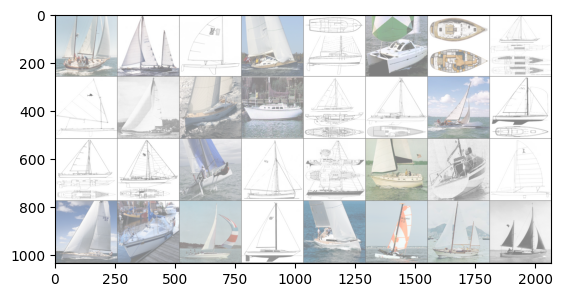

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter._next_data()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
# for i in range(batch_size):
#   imshow(images[i])
#   #print(classes[labels[i].item()], "\n\n")
#   print(dataset_train.categories[int(labels[i])], "\n\n")

In [ ]:
class Net(nn.Module):
    def __init__(self , num_classes):
        super(Net , self).__init__()
        self.model_resnet = resnet50(pretrained=True) # A pretrained resnet 50
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model_resnet(x)
        x = self.fc1(x)
        return x


net = Net()

In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, len(dataset_train.categories))

#     def forward(self, x):
#         x = self.pool(nn.functional.relu(self.conv1(x)))
#         x = self.pool(nn.functional.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
epochs = 100
steps = 0
running_loss = 0
print_every = 100
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = net(inputs)
        
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in testloader:

                    inputs, labels = inputs.to(device),  labels.to(device)
                    logps = net.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =  top_class == labels.view(*top_class.shape)
                    accuracy +=   torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            net.train()
torch.save(net, 'hull_type.pth')

/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100.. Train loss: 2.961.. Test loss: 3.184.. Test accuracy: 0.187


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/100.. Train loss: 2.376.. Test loss: 2.649.. Test accuracy: 0.282


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/100.. Train loss: 2.087.. Test loss: 2.444.. Test accuracy: 0.335


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/100.. Train loss: 2.007.. Test loss: 2.430.. Test accuracy: 0.357


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/100.. Train loss: 1.740.. Test loss: 2.357.. Test accuracy: 0.357


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/100.. Train loss: 1.695.. Test loss: 3.347.. Test accuracy: 0.249


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/100.. Train loss: 1.458.. Test loss: 2.252.. Test accuracy: 0.384


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/100.. Train loss: 1.331.. Test loss: 2.219.. Test accuracy: 0.395


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/100.. Train loss: 1.174.. Test loss: 2.470.. Test accuracy: 0.375


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/100.. Train loss: 1.018.. Test loss: 2.698.. Test accuracy: 0.393


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/100.. Train loss: 0.823.. Test loss: 2.831.. Test accuracy: 0.388


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/100.. Train loss: 0.723.. Test loss: 2.920.. Test accuracy: 0.368


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/100.. Train loss: 0.539.. Test loss: 2.967.. Test accuracy: 0.385


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/100.. Train loss: 0.346.. Test loss: 2.977.. Test accuracy: 0.352


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/100.. Train loss: 0.332.. Test loss: 3.298.. Test accuracy: 0.321


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/100.. Train loss: 0.311.. Test loss: 3.153.. Test accuracy: 0.336


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/100.. Train loss: 0.226.. Test loss: 3.442.. Test accuracy: 0.359


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/100.. Train loss: 0.153.. Test loss: 3.319.. Test accuracy: 0.392


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/100.. Train loss: 0.154.. Test loss: 3.900.. Test accuracy: 0.290


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/100.. Train loss: 0.129.. Test loss: 3.255.. Test accuracy: 0.380


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/100.. Train loss: 0.123.. Test loss: 3.569.. Test accuracy: 0.348


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/100.. Train loss: 0.063.. Test loss: 3.816.. Test accuracy: 0.371


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/100.. Train loss: 0.110.. Test loss: 3.226.. Test accuracy: 0.400


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/100.. Train loss: 0.118.. Test loss: 3.725.. Test accuracy: 0.323


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/100.. Train loss: 0.163.. Test loss: 3.350.. Test accuracy: 0.387


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/100.. Train loss: 0.093.. Test loss: 4.111.. Test accuracy: 0.316


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/100.. Train loss: 0.211.. Test loss: 3.194.. Test accuracy: 0.379


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/100.. Train loss: 0.155.. Test loss: 3.496.. Test accuracy: 0.378


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 16/100.. Train loss: 0.184.. Test loss: 3.540.. Test accuracy: 0.371


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 16/100.. Train loss: 0.136.. Test loss: 3.651.. Test accuracy: 0.380


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 17/100.. Train loss: 0.099.. Test loss: 3.211.. Test accuracy: 0.389


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 17/100.. Train loss: 0.056.. Test loss: 3.923.. Test accuracy: 0.369


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 18/100.. Train loss: 0.061.. Test loss: 3.472.. Test accuracy: 0.398


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 18/100.. Train loss: 0.046.. Test loss: 3.698.. Test accuracy: 0.414


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 19/100.. Train loss: 0.053.. Test loss: 3.801.. Test accuracy: 0.403


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 20/100.. Train loss: 0.064.. Test loss: 4.700.. Test accuracy: 0.317


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 20/100.. Train loss: 0.170.. Test loss: 3.847.. Test accuracy: 0.350


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 21/100.. Train loss: 0.132.. Test loss: 3.678.. Test accuracy: 0.372


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 21/100.. Train loss: 0.101.. Test loss: 3.621.. Test accuracy: 0.331


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 22/100.. Train loss: 0.119.. Test loss: 3.693.. Test accuracy: 0.381


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 22/100.. Train loss: 0.090.. Test loss: 3.520.. Test accuracy: 0.364


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 23/100.. Train loss: 0.079.. Test loss: 3.841.. Test accuracy: 0.333


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 23/100.. Train loss: 0.075.. Test loss: 3.932.. Test accuracy: 0.378


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 24/100.. Train loss: 0.035.. Test loss: 3.540.. Test accuracy: 0.418


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 24/100.. Train loss: 0.024.. Test loss: 3.592.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 25/100.. Train loss: 0.008.. Test loss: 3.646.. Test accuracy: 0.428


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 25/100.. Train loss: 0.011.. Test loss: 3.585.. Test accuracy: 0.389


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 26/100.. Train loss: 0.056.. Test loss: 4.231.. Test accuracy: 0.302


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 26/100.. Train loss: 0.075.. Test loss: 3.646.. Test accuracy: 0.376


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 27/100.. Train loss: 0.091.. Test loss: 3.865.. Test accuracy: 0.378


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 27/100.. Train loss: 0.136.. Test loss: 3.744.. Test accuracy: 0.296


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 28/100.. Train loss: 0.092.. Test loss: 3.840.. Test accuracy: 0.378


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 29/100.. Train loss: 0.119.. Test loss: 4.193.. Test accuracy: 0.341


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 29/100.. Train loss: 0.112.. Test loss: 3.897.. Test accuracy: 0.364


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 30/100.. Train loss: 0.068.. Test loss: 3.818.. Test accuracy: 0.396


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 30/100.. Train loss: 0.040.. Test loss: 3.896.. Test accuracy: 0.399


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 31/100.. Train loss: 0.093.. Test loss: 3.541.. Test accuracy: 0.356


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 31/100.. Train loss: 0.098.. Test loss: 3.888.. Test accuracy: 0.345


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 32/100.. Train loss: 0.056.. Test loss: 3.687.. Test accuracy: 0.382


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 32/100.. Train loss: 0.034.. Test loss: 3.762.. Test accuracy: 0.376


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 33/100.. Train loss: 0.023.. Test loss: 4.055.. Test accuracy: 0.385


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 33/100.. Train loss: 0.018.. Test loss: 3.692.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 34/100.. Train loss: 0.006.. Test loss: 3.819.. Test accuracy: 0.414


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 34/100.. Train loss: 0.009.. Test loss: 3.806.. Test accuracy: 0.406


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 35/100.. Train loss: 0.006.. Test loss: 3.783.. Test accuracy: 0.404


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 35/100.. Train loss: 0.005.. Test loss: 3.871.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 36/100.. Train loss: 0.003.. Test loss: 3.897.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 36/100.. Train loss: 0.005.. Test loss: 3.920.. Test accuracy: 0.409


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 37/100.. Train loss: 0.002.. Test loss: 3.906.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 38/100.. Train loss: 0.005.. Test loss: 3.920.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 38/100.. Train loss: 0.001.. Test loss: 3.918.. Test accuracy: 0.417


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 39/100.. Train loss: 0.006.. Test loss: 4.007.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 39/100.. Train loss: 0.003.. Test loss: 3.999.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 40/100.. Train loss: 0.003.. Test loss: 3.956.. Test accuracy: 0.413


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 40/100.. Train loss: 0.002.. Test loss: 4.016.. Test accuracy: 0.406


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 41/100.. Train loss: 0.005.. Test loss: 4.018.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 41/100.. Train loss: 0.003.. Test loss: 4.076.. Test accuracy: 0.409


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 42/100.. Train loss: 0.003.. Test loss: 4.041.. Test accuracy: 0.412


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 42/100.. Train loss: 0.002.. Test loss: 4.059.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 43/100.. Train loss: 0.004.. Test loss: 4.052.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 43/100.. Train loss: 0.004.. Test loss: 4.171.. Test accuracy: 0.414


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 44/100.. Train loss: 0.002.. Test loss: 4.092.. Test accuracy: 0.417


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 44/100.. Train loss: 0.003.. Test loss: 4.205.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 45/100.. Train loss: 0.005.. Test loss: 4.229.. Test accuracy: 0.414


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 45/100.. Train loss: 0.004.. Test loss: 4.089.. Test accuracy: 0.413


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 46/100.. Train loss: 0.003.. Test loss: 4.208.. Test accuracy: 0.419


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 47/100.. Train loss: 0.004.. Test loss: 4.191.. Test accuracy: 0.422


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 47/100.. Train loss: 0.003.. Test loss: 4.202.. Test accuracy: 0.418


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 48/100.. Train loss: 0.092.. Test loss: 4.612.. Test accuracy: 0.160


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 48/100.. Train loss: 1.184.. Test loss: 2.856.. Test accuracy: 0.346


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 49/100.. Train loss: 0.547.. Test loss: 3.158.. Test accuracy: 0.391


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 49/100.. Train loss: 0.128.. Test loss: 3.603.. Test accuracy: 0.383


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 50/100.. Train loss: 0.095.. Test loss: 4.108.. Test accuracy: 0.300


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 50/100.. Train loss: 0.059.. Test loss: 3.575.. Test accuracy: 0.392


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 51/100.. Train loss: 0.049.. Test loss: 3.539.. Test accuracy: 0.382


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 51/100.. Train loss: 0.050.. Test loss: 3.650.. Test accuracy: 0.397


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 52/100.. Train loss: 0.021.. Test loss: 3.734.. Test accuracy: 0.420


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 52/100.. Train loss: 0.016.. Test loss: 3.739.. Test accuracy: 0.402


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 53/100.. Train loss: 0.011.. Test loss: 3.866.. Test accuracy: 0.416


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 53/100.. Train loss: 0.007.. Test loss: 3.883.. Test accuracy: 0.416


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 54/100.. Train loss: 0.004.. Test loss: 3.931.. Test accuracy: 0.417


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 54/100.. Train loss: 0.005.. Test loss: 3.969.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 55/100.. Train loss: 0.003.. Test loss: 3.945.. Test accuracy: 0.420


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 56/100.. Train loss: 0.011.. Test loss: 3.936.. Test accuracy: 0.392


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 56/100.. Train loss: 0.027.. Test loss: 4.073.. Test accuracy: 0.373


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 57/100.. Train loss: 0.073.. Test loss: 4.289.. Test accuracy: 0.350


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 57/100.. Train loss: 0.045.. Test loss: 4.257.. Test accuracy: 0.381


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 58/100.. Train loss: 0.105.. Test loss: 3.975.. Test accuracy: 0.326


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 58/100.. Train loss: 0.088.. Test loss: 4.148.. Test accuracy: 0.328


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 59/100.. Train loss: 0.074.. Test loss: 3.755.. Test accuracy: 0.379


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 59/100.. Train loss: 0.026.. Test loss: 3.874.. Test accuracy: 0.384


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 60/100.. Train loss: 0.017.. Test loss: 4.013.. Test accuracy: 0.397


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 60/100.. Train loss: 0.009.. Test loss: 4.036.. Test accuracy: 0.420


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 61/100.. Train loss: 0.015.. Test loss: 3.870.. Test accuracy: 0.402


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 61/100.. Train loss: 0.006.. Test loss: 3.949.. Test accuracy: 0.402


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 62/100.. Train loss: 0.004.. Test loss: 4.034.. Test accuracy: 0.406


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 62/100.. Train loss: 0.003.. Test loss: 4.068.. Test accuracy: 0.406


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 63/100.. Train loss: 0.003.. Test loss: 4.066.. Test accuracy: 0.412


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 63/100.. Train loss: 0.004.. Test loss: 4.090.. Test accuracy: 0.413


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 64/100.. Train loss: 0.003.. Test loss: 4.136.. Test accuracy: 0.413


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 65/100.. Train loss: 0.003.. Test loss: 4.180.. Test accuracy: 0.416


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 65/100.. Train loss: 0.001.. Test loss: 4.165.. Test accuracy: 0.416


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 66/100.. Train loss: 0.005.. Test loss: 4.170.. Test accuracy: 0.415


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 66/100.. Train loss: 0.002.. Test loss: 4.244.. Test accuracy: 0.417


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 67/100.. Train loss: 0.003.. Test loss: 4.310.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 67/100.. Train loss: 0.003.. Test loss: 4.267.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 68/100.. Train loss: 0.159.. Test loss: 4.134.. Test accuracy: 0.235


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 68/100.. Train loss: 0.339.. Test loss: 3.709.. Test accuracy: 0.365


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 69/100.. Train loss: 0.166.. Test loss: 3.647.. Test accuracy: 0.372


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 69/100.. Train loss: 0.050.. Test loss: 3.843.. Test accuracy: 0.367


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 70/100.. Train loss: 0.046.. Test loss: 3.713.. Test accuracy: 0.383


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 70/100.. Train loss: 0.026.. Test loss: 3.841.. Test accuracy: 0.368


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 71/100.. Train loss: 0.024.. Test loss: 3.914.. Test accuracy: 0.394


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 71/100.. Train loss: 0.012.. Test loss: 3.956.. Test accuracy: 0.399


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 72/100.. Train loss: 0.005.. Test loss: 3.998.. Test accuracy: 0.410


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 72/100.. Train loss: 0.005.. Test loss: 4.015.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 73/100.. Train loss: 0.009.. Test loss: 3.991.. Test accuracy: 0.402


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 74/100.. Train loss: 0.010.. Test loss: 4.049.. Test accuracy: 0.396


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 74/100.. Train loss: 0.008.. Test loss: 4.283.. Test accuracy: 0.389


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 75/100.. Train loss: 0.012.. Test loss: 4.111.. Test accuracy: 0.404


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 75/100.. Train loss: 0.003.. Test loss: 4.171.. Test accuracy: 0.411


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 76/100.. Train loss: 0.008.. Test loss: 4.221.. Test accuracy: 0.388


/home/chris/.local/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 76/100.. Train loss: 0.011.. Test loss: 4.029.. Test accuracy: 0.403
